## Подключим необходимые библиотеки и загрузим данные

In [66]:
# Подключим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Загрузим данные

payments = pd.read_csv('https://raw.githubusercontent.com/sergigusev/Datasets/refs/heads/main/payments_test.csv')
plan = pd.read_csv('https://raw.githubusercontent.com/sergigusev/Datasets/refs/heads/main/plan_test.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/sergigusev/Datasets/refs/heads/main/orders_test.csv')

Необходимо проанализировать данные о выданных кредитах и платежах, чтобы выявить динамику просрочки и определить, наблюдается ли тенденция к росту или снижению

## Подготовка данных

In [68]:
# Преобразуем даты в datetime объекты

for df in [payments, plan, orders]:
  for col in df.columns:
    if 'at' in col:
      df[col] = pd.to_datetime(df[col])

In [69]:
# Нормализуем дату у переменной paid_at, чтобы она была в одном формате с переменной plan_at

payments['paid_at'] = payments['paid_at'].dt.normalize()

In [70]:
# Посмотрим на таблицу plan

display(plan)

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.00
1,400001732,2022-07-02,9450.00
2,400001732,2022-08-01,12170.00
3,400001732,2022-08-31,14890.00
4,400001732,2022-09-30,17610.00
...,...,...,...
420277,495177509,2022-12-22,34248.70
420278,495177509,2023-01-06,36863.04
420279,495177509,2023-01-21,39440.38
420280,495177509,2023-02-05,41980.73


In [71]:
# Посмотрим на уникальные значения в таблице plan
print(plan['order_id'].nunique())

55748


In [72]:
# Посмотрим на таблицу payments

display(payments)

,order_id,paid_at,paid_sum
0,400013633,2022-06-02,2500.00
1,400018480,2022-06-02,1070.00
2,400032001,2022-06-02,4200.00
3,400033195,2022-06-02,2850.00
4,400039407,2022-06-02,10100.00
...,...,...,...
143279,469255350,2022-12-08,343.99
143280,452985418,2022-12-08,984.83
143281,490824962,2022-12-08,866.04
143282,480026135,2022-12-08,1193.25


In [73]:
# Посмотрим на уникальные значения в таблице payments
print(payments['order_id'].nunique())

53730


In [74]:
# Посмотрим на таблицу orders

display(orders)

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0
...,...,...,...,...,...
55743,495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaT,9500.0
55744,495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0
55745,495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0
55746,495176080,2022-08-31 23:47:20.997,2022-08-31 23:49:03.027,2022-09-12 00:58:57.037,5000.0


In [75]:
# Посмотрим на уникальные значения в таблице orders
orders['order_id'].nunique()

55748

В итоге перед объединением трёх таблиц по общему ключу **order_id** необходимо провести агрегацию, чтобы избежать ненужного увеличения количества строк в итоговой таблице для анализа

In [76]:
'''
Проведём агрегирование таблицы plan.
В итоге каждый order_id будет иметь одну запись с последней плановой датой платежа
и накопленной итоговой суммой.
'''
plan_agg = plan.sort_values(by='plan_at').groupby('order_id').agg({
    'plan_at': 'last',  # Последняя плановая дата для каждого order_id
    'plan_sum_total': 'last'  # Последняя накопленная сумма для каждого order_id
}).reset_index()

In [77]:
'''
Аналогично сделаем для таблицы payments.
Выберем последнюю дату фактического платежа с накопленной суммой для каждого order_id
'''
payments_agg = payments.sort_values(by='paid_at').groupby('order_id').agg({
    'paid_at': 'last',  # Последняя дата фактического платежа
    'paid_sum': 'sum'   # Общая сумма фактических платежей
}).reset_index()

In [78]:
'''
Далее можно объединять таблицы в одну.
Основной таблицей является таблица orders.
К ней присоединим таблицы plan_agg и payments_agg через left join
'''
data = pd.merge(orders, plan_agg, on='order_id', how='left')
data = pd.merge(data, payments_agg, on='order_id', how='left')

In [79]:
# Посмотрим на финальную таблицу data

display(data)

,order_id,created_at,put_at,closed_at,issued_sum,plan_at,plan_sum_total,paid_at,paid_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-11-29,23050.00,2022-10-17,23050.00
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0,2022-06-17,23000.00,2022-06-02,20200.00
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0,2022-12-02,8579.10,2022-06-21,8579.10
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0,2022-06-18,12628.36,2022-07-12,12628.36
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0,2022-06-17,6013.70,2022-06-22,6013.70
...,...,...,...,...,...,...,...,...,...
55743,495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaT,9500.0,2023-02-20,16553.89,2022-09-01,2500.00
55744,495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0,2023-02-24,21243.04,2022-09-16,21243.04
55745,495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0,2022-09-16,4600.00,2022-09-09,4320.00
55746,495176080,2022-08-31 23:47:20.997,2022-08-31 23:49:03.027,2022-09-12 00:58:57.037,5000.0,2022-09-15,5750.00,2022-09-12,5600.00


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        55748 non-null  int64         
 1   created_at      55748 non-null  datetime64[ns]
 2   put_at          55748 non-null  datetime64[ns]
 3   closed_at       46472 non-null  datetime64[ns]
 4   issued_sum      55748 non-null  float64       
 5   plan_at         55748 non-null  datetime64[ns]
 6   plan_sum_total  55748 non-null  float64       
 7   paid_at         53730 non-null  datetime64[ns]
 8   paid_sum        53730 non-null  float64       
dtypes: datetime64[ns](5), float64(3), int64(1)
memory usage: 3.8 MB


Типы данных приведены в норму для оптимальной работы. Мы имеем 5 атрибутов с типом datetime и 3 атрибута с численным типом данных

In [81]:
data.isna().sum()

,0
order_id,0
created_at,0
put_at,0
closed_at,9276
issued_sum,0
plan_at,0
plan_sum_total,0
paid_at,2018
paid_sum,2018


Пропущенные значения наблюдаются в атрибутах closed_at, paid_at и paid_sum. Некоторые просроченные платежи, как раз, должны находиться в пропусках paid_at и paid_sum. В пропусках closed_at могут находиться не просроченные платежи, тк данные актуальны на 08.12.2022. Встречаются плановые даты платежей (plan_at), которые допускают оплату без просрочки после 08.12.2022

In [82]:
# Количество дубликатов
data.duplicated().sum()

0

Дубликатов не обнаружено, так как с ними уже была проведена работа выше во время агрегации

## Расчёты

Платеж просрочен, если:
1. paid_at - plan_at > 0
2. 08.12.2022 > plan_at
3. paid_sum < plan_sum_total


In [83]:
# Закрепим "актуальную дату" для проверки просрочки
actual_date = pd.to_datetime("2022-12-08")

# Рассчитаем просрочку по условиям:
data['payment_overdue'] = np.where(
    # Условие 1: Платеж не совершен, а плановая дата прошла
    (data['paid_at'].isna()) & (actual_date > data['plan_at']),
    1,
    np.where(
        # Условие 2: Платеж совершен с задержкой или сумма неполная
        (~data['paid_at'].isna()) &
        ((data['paid_at'] > data['plan_at']) | (data['paid_sum'] < data['plan_sum_total'])),
        1,
        0  # Иначе платеж был совершен вовремя
    )
)

In [84]:
# Проверим просрочку: где 1 - платёж просрочен, где 0 - платеж совершен вовремя
data['payment_overdue'].value_counts()

,count
payment_overdue,
0,28269
1,27479


В итоге получаем: 27479 просроченных платежей и 28269 оплаченных вовремя

В качестве показателей для визуализации выберу следующее:

1. Динамика доли просроченных платежей по месяцам

2. Динамика средней суммы просроченных платежей по месяцам

3. Количество просроченных платежей по месяцам

4. Общая сумма просроченных платежей по месяцам

In [85]:
'''
Далее необходимо агрегировать данные для дальнейшей визуализации.
Агрегацию проведем по просроченным платежам по месяцам.
'''
# Создадим новый атрибут с месяцем на основе плановой даты платежа
data['month'] = data['plan_at'].dt.to_period('M')

# Отфильтруем датасет по plan_at по дате актуальности данных
data = data[data['plan_at'] <= pd.to_datetime('2022-12-08')].copy()

# Создаем новый атрибут с суммой просроченной части платежа
data['overdue_sum'] = np.where(
    data['payment_overdue'] == 1,
    np.where(
        data['paid_sum'].isna(),  # Если paid_sum пустой
        data['plan_sum_total'],   # overdue_sum равен plan_sum_total
        np.maximum(0, data['plan_sum_total'] - data['paid_sum'])  # Берем максимум с 0, чтобы избежать отрицательных значений
    ),
    0
)

# Отфильтруем только просроченные платежи
overdue_data = data[data['payment_overdue'] == 1]

# Рассчитаем необходимые показатели по месяцам
monthly_overdue_stats = overdue_data.groupby('month').agg(
    overdue_count=('payment_overdue', 'count'),  # Количество просроченных платежей
    overdue_sum_total=('overdue_sum', 'sum'),      # Общая сумма просроченных платежей
    overdue_sum_mean=('overdue_sum', 'mean'),      # Средняя сумма просроченных платежей
)

# Рассчитаем долю просроченных платежей по отношению ко всем платежам
monthly_total = data.groupby('month')['order_id'].count()  # Общее количество платежей по месяцам
monthly_overdue_stats['overdue_ratio'] = monthly_overdue_stats['overdue_count'] / monthly_total
monthly_overdue_stats.reset_index(inplace=True)

In [86]:
# Посмотрим на количество просроченных и оплаченных вовремя платежей после фильтрации по дате актуальности данных
data['payment_overdue'].value_counts()

,count
payment_overdue,
1,19591
0,5936


Количество просроченных платежей более, чем в три раза больше количества оплаченных вовремя

In [87]:
# Посмотрим на таблицу агрегации
display(monthly_overdue_stats)

,month,overdue_count,overdue_sum_total,overdue_sum_mean,overdue_ratio
0,2022-06,2249,6621667.25,2944.271787,0.898163
1,2022-07,6146,25834009.04,4203.385786,0.878879
2,2022-08,6582,5163532.60,784.492950,0.882306
3,2022-09,3573,3080294.81,862.103221,0.863878
4,2022-10,139,387034.51,2784.420935,0.863354
5,2022-11,321,2523461.02,7861.249283,0.204719
6,2022-12,581,4312385.65,7422.350516,0.214787


## Визуализация

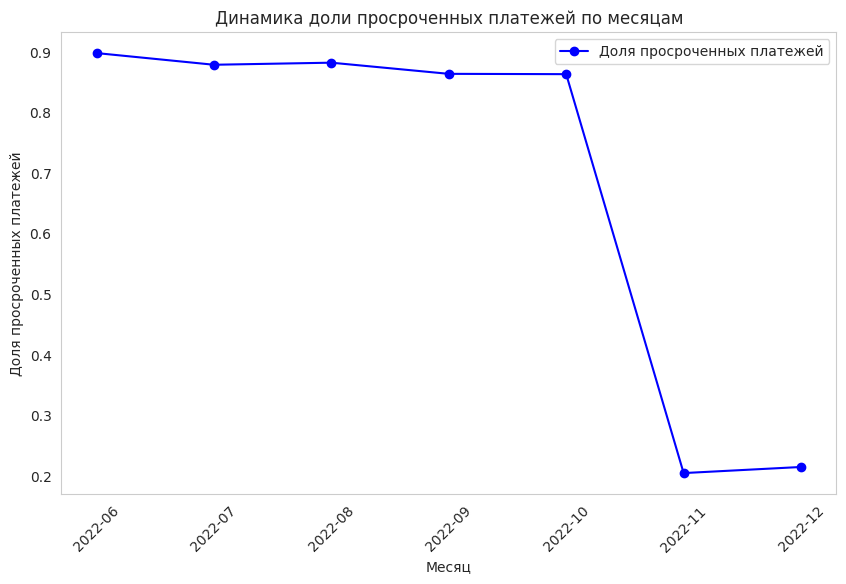

In [88]:
# Динамика доли просроченных платежей по месяцам

plt.figure(figsize=(10, 6))
plt.plot(
    monthly_overdue_stats['month'].astype(str),
    monthly_overdue_stats['overdue_ratio'],
    marker='o', color='b',
    label='Доля просроченных платежей'
)
plt.title("Динамика доли просроченных платежей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Доля просроченных платежей")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

**Вывод:** на графике видно, что в целом доля просроченных платежей к общему количеству составляет довольно высокий процент. В период с 2022.06 по 2022.10 доля держится около 90%. Далее наблюдается резкое падение до 20% 2022.11. После график снова начинает расти. Предположу, что такой резкий спад связан с ограничением по данным на дату актуальности. Возможно, после декабря опять наблюдается резкий подъём графика к предыдущим значениям.

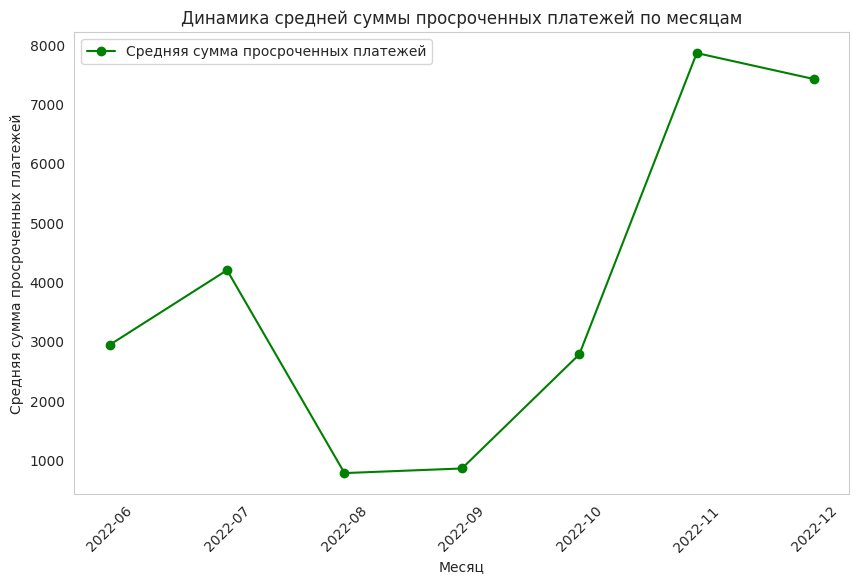

In [89]:
# Динамика средней суммы просроченных платежей по месяцам

plt.figure(figsize=(10, 6))
plt.plot(
    monthly_overdue_stats['month'].astype(str),
    monthly_overdue_stats['overdue_sum_mean'],
    marker='o',
    color='g',
    label='Средняя сумма просроченных платежей'
)
plt.title("Динамика средней суммы просроченных платежей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Средняя сумма просроченных платежей")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

**Вывод:** в июне 2022 средняя сумма просроченных платежей составляет около 3000 рублей. Далее в июле происходит рост до 4200. После резкий спад на конец лета - начало осени в район до 1000. Далее происходит стремительный рост к зимним месяцам: 3000 в октябре, 8000 в ноябре. В декабре средняя сумма просроченных платежей продолжает держаться на высокой отметке. Предположу, что подобная тенденция связана с тем, что у клиентов больше затрат после лета (сезона отпусков), подготовка к учебному сезону, больше праздников, подготовка к новогодним праздникам.

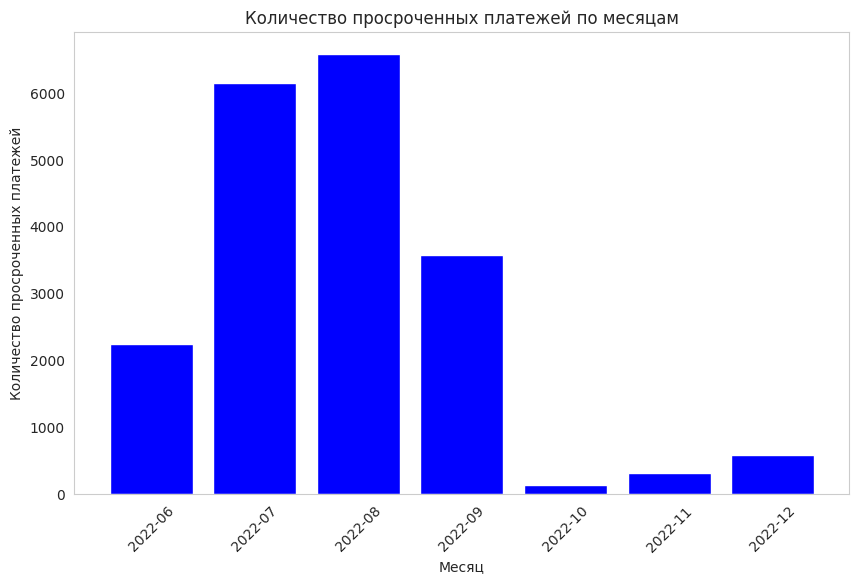

In [90]:
# Количество просроченных платежей по месяцам

plt.figure(figsize=(10, 6))
plt.bar(
    monthly_overdue_stats['month'].astype(str),
    monthly_overdue_stats['overdue_count'],
    color='b'
)
plt.title("Количество просроченных платежей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество просроченных платежей")
plt.xticks(rotation=45)
plt.grid()
plt.show()

**Вывод:** в июне 2022 количество просроченных платежей составляет около 2200. Далее в июле наблюдается резкий рост до 6100, который продолжается в августе и доходит до пика около 6500. С сентября начинается резкий спад, который продолжается в октябре. Далее к зиме снова просматривается рост. В октябре, ноябре, декабре количество просроченных платежей держится до 1000. Исходя из проанализированных данных по этому графику, клиенты стали платить вовремя после лета.

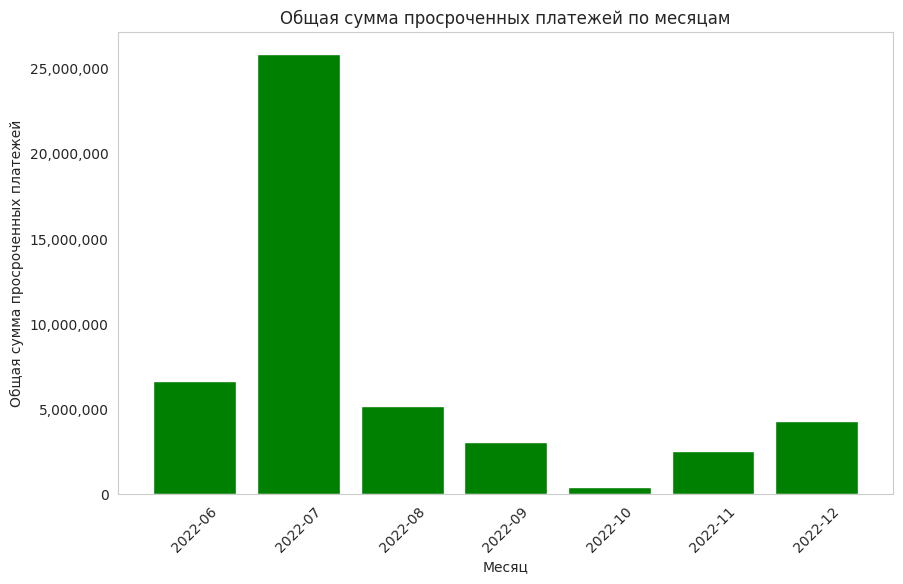

In [91]:
# Общая сумма просроченных платежей по месяцам

plt.figure(figsize=(10, 6))
plt.bar(
    monthly_overdue_stats['month'].astype(str),
    monthly_overdue_stats['overdue_sum_total'],
    color='g'
)
plt.title("Общая сумма просроченных платежей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Общая сумма просроченных платежей")
plt.xticks(rotation=45)
# Добавим форматирование с разделением на тысячи для наглядности
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
plt.grid()
plt.show()

**Вывод:** в июне 2022 общая сумма просроченных платежей составляет около 6 млн рублей. В июле  наблюдается резкий рост до 25 млн рублей, затем снижение до 5 млн рублей в августе, которое продолжается в сентябре и приходит в свой минимум в октябре (менее 500 тысяч). Далее виден незначительный рост графика в ноябре, который продолжается в декабре и и почти доходит до 5 млн рублей. Опять же, предположу, что такая тенденция связана с летними месяцами, когда клиенты могут ощущать беззаботное время и не слишком беспокоятся по поводу платежей. В конце осени клиенты начинают готовиться к новогодним праздникам.

## Итого

Исходя и проведенного аналитического отчёта можно отметить тенденцию характера поведения клиентов с точки зрения просрочки платежей:

- В летние месяцы дикамика растёт по всем проанализированным показателям либо остаётся на пике

- Осенью динамика просрочки снижается и держится на своём минимуме

- К зиме снова начинает расти

Предположу такое мнение:

Лето считается беззаботной порой. Тёплое время, сезон отпусков. Клиенты хотят отдохнуть от своей рутины и перестают заботиться оо платежах и кредитах. Осенью многие берут себя в руки. Появляется активность после летнего отдыха. Далее ближе к зимнему времени года у клиентов появляются новые цели, желания, заботы и задачи перед концом года и к новогодним праздникам.